<div align=center>

<p></p>
<p></p>
<font size=5>
In the Name of God
<font/>
<p></p>
 <br/>
    <br/>
<font color=#4d7db8>
Sharif University of Technology - Department of Electrical Engineering
</font>
<p></p>
<font color=#4d7db8>
Introduction To Machine Learning - Dr. Sajjad Amini
</font>
<br/>
<br/>
Spring Semester 1401-02

<div/>

<hr/>
		<div align=center>
		    <font color=red size=6>
			    <br />
Project - 3rd Phase
<br />
Image Super Resolution using Autoencoder
			</font>
    <br/>
<font size=4>
			<br/><br/>
Due on Tir 10th
                <br/><b>
              Cheating is Strongly Prohibited
                </b><br/><br/>
                <font color=green>
Should you have any questions concerning the project, please feel free to ask via Telegram.
     </font>
</font>
                <br/>
    </div>

# Personal Info
<hr/>
    <div class="column" align=center>
    <font size=4>
        <div class="column">
        <br />
            student_number = 99106493
            <br />
            Name = Mohammad
            <br />
            Last_Name = Ghafourian
        </div>
        <div class="column">
        <br />
            student_number = 99106522
            <br />
            Name = Shabnam
            <br />
            Last_Name = Fazliani
        </div>
    </font>
    </div>


1. Download the "image super resolution (from unsplash)" dataset and split it's validation set to new validation set and test set.
2. Design and train an AutoEncoder using `PyTorch` (not `TensorFlow`) on the dataset to enhance the resolution of images from low resolution to high resolution.
3. plot learning curve and visualize low resolution images of test set, their corresponding high resolution images and their reconstructed versions side by side.

# Import Necessary Libraries

In [1]:
import torch
import torchvision
from torchvision.transforms import ToTensor,Compose , Normalize
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Dataset
from torchvision.transforms import transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Load Dataset and Prepare It

In [2]:
! pip install kaggle
#--------------------
! mkdir ~/.kaggle
#--------------------
! cp kaggle.json ~/.kaggle/
#--------------------
! chmod 600 ~/.kaggle/kaggle.json
#--------------------
! kaggle datasets download quadeer15sh/image-super-resolution-from-unsplash
#--------------------
! unzip /content/image-super-resolution-from-unsplash.zip

Streaming output truncated to the last 5000 lines.
  inflating: Image Super Resolution - Unsplash/high res/1013.jpg  
  inflating: Image Super Resolution - Unsplash/high res/1014.jpg  
  inflating: Image Super Resolution - Unsplash/high res/1015.jpg  
  inflating: Image Super Resolution - Unsplash/high res/1016.jpg  
  inflating: Image Super Resolution - Unsplash/high res/1017.jpg  
  inflating: Image Super Resolution - Unsplash/high res/1018.jpg  
  inflating: Image Super Resolution - Unsplash/high res/1019.jpg  
  inflating: Image Super Resolution - Unsplash/high res/102.jpg  
  inflating: Image Super Resolution - Unsplash/high res/1020.jpg  
  inflating: Image Super Resolution - Unsplash/high res/1021.jpg  
  inflating: Image Super Resolution - Unsplash/high res/1022.jpg  
  inflating: Image Super Resolution - Unsplash/high res/1023.jpg  
  inflating: Image Super Resolution - Unsplash/high res/1024.jpg  
  inflating: Image Super Resolution - Unsplash/high res/1025.jpg  
  inflating:

In [3]:
# Set up the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
class ImageDataset(Dataset):
    def __init__(self, csv_file, root_dir_low, root_dir_high, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir_low = root_dir_low
        self.root_dir_high = root_dir_high
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name_low = os.path.join(self.root_dir_low, self.data.iloc[idx, 0])
        img_name_high = os.path.join(self.root_dir_high, self.data.iloc[idx, 1])
        image_low = Image.open(img_name_low).convert('RGB')
        image_high = Image.open(img_name_high).convert('RGB')
        if self.transform:
            image_low = self.transform(image_low)
            image_high = self.transform(image_high)

        return image_low, image_high


In [5]:
# Define the dataset and data loader
base_dir = '/content/Image Super Resolution - Unsplash'
high_dir = os.path.join(base_dir, 'high res')
low_dir = os.path.join(base_dir, 'low res')
csv_file = os.path.join(base_dir, 'image_data.csv')

batch_size = 4

transform = transforms.Compose([
    transforms.Resize((800, 1200)),
    transforms.ToTensor()
])

dataset = ImageDataset(csv_file=csv_file, root_dir_low=low_dir, root_dir_high=high_dir, transform=transform)
#split the csv file instead of pics beacase of lack of Ram
train_data, val_data = train_test_split(dataset.data, test_size=0.2, random_state=42)

train_dataset = ImageDataset(csv_file=csv_file, root_dir_low=low_dir, root_dir_high=high_dir, transform=transform)
train_dataset.data = train_data
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = ImageDataset(csv_file=csv_file, root_dir_low=low_dir, root_dir_high=high_dir, transform=transform)
val_dataset.data = val_data
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


# Define Your Model
torch neural network model

In [6]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=1, padding=1, output_padding=0),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=1, padding=1 ,output_padding=0),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [7]:
def train(model, train_loader ,val_dataloader, criterion, optimizer, num_epochs, learning_rate, device):
    # Train the model
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (low_res, high_res) in enumerate(train_loader, 0):
            # Get the inputs and move them to the device
            low_res = low_res.to(device)
            high_res = high_res.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass, backward pass, and optimize
            outputs = model(low_res)
            #print(outputs.shape)
            loss = criterion(outputs, high_res)
            loss.backward()
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
            if i % 100 == 99:
                print('[%d, %5d] train loss: %f' %
                      (epoch + 1, i + 1, running_loss / 100))
                train_losses.append(running_loss/100)
                running_loss = 0.0

        model.eval()
        val_loss = 0.0
        with torch.no_grad():

            for j, (low_res, high_res) in enumerate(val_dataloader,0):
                low_res = low_res.to(device)
                high_res = high_res.to(device)
                outputs = model(low_res)
                loss = criterion(outputs, high_res)
                val_loss += loss.item()
                if j % 100 == 99:
                    print('[%d, %5d] validation loss: %f' %
                                (epoch + 1,j+1, val_loss / 100))
                    val_loss /= 10
                    val_losses.append(val_loss)



    print('Finished training')
    return train_losses, val_losses

# Fit The Model
Also Define optimizer, Criterion and other parameters

In [ ]:
# Define the loss function and optimizer

model = Autoencoder().to(device)
# model = torch.jit.load('model_scripted.pt')
# model.eval()
# Train the model
learning_rate = 0.002
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
num_epochs = 20
train_losses, val_losses = train(model, train_dataloader, val_dataloader, criterion=criterion,
        optimizer=optimizer, num_epochs=num_epochs, learning_rate = learning_rate, device=device)
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('model_scripted.pt') # Save

[1,   100] train loss: 0.041073
[1,   200] train loss: 0.013586
[1,   300] train loss: 0.013502
[1,   400] train loss: 0.013998
[1,   500] train loss: 0.012125
[1,   600] train loss: 0.012977
[1,   700] train loss: 0.012406
[1,    10] validation loss: 0.016065
[1,    20] validation loss: 0.017653
[1,    30] validation loss: 0.019782
[1,    40] validation loss: 0.017714
[1,    50] validation loss: 0.018060
[1,    60] validation loss: 0.017078
[1,    70] validation loss: 0.017984
[1,    80] validation loss: 0.014167
[1,    90] validation loss: 0.017082
[1,   100] validation loss: 0.019334
[1,   110] validation loss: 0.018852
[1,   120] validation loss: 0.020358
[1,   130] validation loss: 0.018156
[1,   140] validation loss: 0.018348
[1,   150] validation loss: 0.018374
[1,   160] validation loss: 0.019012
[1,   170] validation loss: 0.018152
[1,   180] validation loss: 0.022431
[2,   100] train loss: 0.012920
[2,   200] train loss: 0.010981
[2,   300] train loss: 0.011041
[2,   400] tra

In [ ]:
model = torch.jit.load('model_scripted.pt')
model.eval()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
num_epochs = 20
train_losses1, val_losses1 = train(model, train_dataloader, val_dataloader, criterion=criterion,
        optimizer=optimizer, num_epochs=num_epochs, learning_rate = learning_rate, device=device)
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('model_scripted1.pt') # Save

[1,   100] train loss: 0.004079
[1,   200] train loss: 0.003856
[1,   300] train loss: 0.004520
[1,   400] train loss: 0.003446
[1,   500] train loss: 0.003480
[1,   600] train loss: 0.003419
[1,   700] train loss: 0.003340
[1,   100] validation loss: 0.003820
[2,   100] train loss: 0.004280
[2,   200] train loss: 0.004051
[2,   300] train loss: 0.003814
[2,   400] train loss: 0.004050
[2,   500] train loss: 0.003438
[2,   600] train loss: 0.003439
[2,   700] train loss: 0.004010
[2,   100] validation loss: 0.003479
[3,   100] train loss: 0.004454
[3,   200] train loss: 0.004148
[3,   300] train loss: 0.003350
[3,   400] train loss: 0.003238
[3,   500] train loss: 0.003367
[3,   600] train loss: 0.003659
[3,   700] train loss: 0.003505
[3,   100] validation loss: 0.003218
[4,   100] train loss: 0.003428
[4,   200] train loss: 0.004985
[4,   300] train loss: 0.003466
[4,   400] train loss: 0.003484
[4,   500] train loss: 0.003895
[4,   600] train loss: 0.003433
[4,   700] train loss: 0.

In [ ]:
learning_rate = 0.0005
model = torch.jit.load('model_scripted1.pt')
model.eval()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
num_epochs = 10
train_losses2, val_losses2 = train(model, train_dataloader, val_dataloader, criterion=criterion,
        optimizer=optimizer, num_epochs=num_epochs, learning_rate = learning_rate, device=device)
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('model_scripted2.pt') # Save

[1,   100] train loss: 0.003516
[1,   200] train loss: 0.003181
[1,   300] train loss: 0.003198
[1,   400] train loss: 0.002899
[1,   500] train loss: 0.002749
[1,   600] train loss: 0.003347
[1,   700] train loss: 0.003224
[1,   100] validation loss: 0.003013
[2,   100] train loss: 0.003060
[2,   200] train loss: 0.002959
[2,   300] train loss: 0.002949
[2,   400] train loss: 0.003274
[2,   500] train loss: 0.003279
[2,   600] train loss: 0.003157
[2,   700] train loss: 0.003122
[2,   100] validation loss: 0.002986
[3,   100] train loss: 0.002883
[3,   200] train loss: 0.003156
[3,   300] train loss: 0.003188
[3,   400] train loss: 0.003239
[3,   500] train loss: 0.003046
[3,   600] train loss: 0.002925
[3,   700] train loss: 0.003335
[3,   100] validation loss: 0.003051
[4,   100] train loss: 0.003173
[4,   200] train loss: 0.002962
[4,   300] train loss: 0.003006
[4,   400] train loss: 0.002855
[4,   500] train loss: 0.003032
[4,   600] train loss: 0.002516
[4,   700] train loss: 0.

In [8]:
learning_rate = 0.0001
model = torch.jit.load('model_scripted2.pt')
model.eval()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
num_epochs = 10
train_losses3, val_losses3 = train(model, train_dataloader, val_dataloader, criterion=criterion,
        optimizer=optimizer, num_epochs=num_epochs, learning_rate = learning_rate, device=device)
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('model_scripted3.pt') # Save

[1,   100] train loss: 0.002205
[1,   200] train loss: 0.002356
[1,   300] train loss: 0.002466
[1,   400] train loss: 0.002512
[1,   500] train loss: 0.002386
[1,   600] train loss: 0.002397
[1,   700] train loss: 0.002453
[1,   100] validation loss: 0.002222
[2,   100] train loss: 0.002066
[2,   200] train loss: 0.002384
[2,   300] train loss: 0.002451
[2,   400] train loss: 0.002453
[2,   500] train loss: 0.002726
[2,   600] train loss: 0.002364
[2,   700] train loss: 0.002185
[2,   100] validation loss: 0.002215
[3,   100] train loss: 0.002220
[3,   200] train loss: 0.002298
[3,   300] train loss: 0.002516
[3,   400] train loss: 0.002297
[3,   500] train loss: 0.002718
[3,   600] train loss: 0.002376
[3,   700] train loss: 0.002197
[3,   100] validation loss: 0.002209
[4,   100] train loss: 0.002369
[4,   200] train loss: 0.002755
[4,   300] train loss: 0.002201
[4,   400] train loss: 0.002258
[4,   500] train loss: 0.002259
[4,   600] train loss: 0.002354
[4,   700] train loss: 0.

In [8]:
learning_rate = 0.0001
model = torch.jit.load('model_scripted3.pt')
model.eval()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
num_epochs = 20
train_losses4, val_losses4 = train(model, train_dataloader, val_dataloader, criterion=criterion,
        optimizer=optimizer, num_epochs=num_epochs, learning_rate = learning_rate, device=device)
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('model_scripted4.pt') # Save

[1,   100] train loss: 0.002626
[1,   200] train loss: 0.002447
[1,   300] train loss: 0.002713
[1,   400] train loss: 0.002229
[1,   500] train loss: 0.002071
[1,   600] train loss: 0.002246
[1,   700] train loss: 0.002147
[1,   100] validation loss: 0.002185
[2,   100] train loss: 0.002493
[2,   200] train loss: 0.002551
[2,   300] train loss: 0.002321
[2,   400] train loss: 0.002292
[2,   500] train loss: 0.002333
[2,   600] train loss: 0.002179
[2,   700] train loss: 0.002522
[2,   100] validation loss: 0.002176
[3,   100] train loss: 0.002447
[3,   200] train loss: 0.002183
[3,   300] train loss: 0.002355
[3,   400] train loss: 0.002665
[3,   500] train loss: 0.002192
[3,   600] train loss: 0.002336
[3,   700] train loss: 0.002267
[3,   100] validation loss: 0.002173
[4,   100] train loss: 0.002598
[4,   200] train loss: 0.002338
[4,   300] train loss: 0.002196
[4,   400] train loss: 0.002289
[4,   500] train loss: 0.002226
[4,   600] train loss: 0.002388
[4,   700] train loss: 0.

In [12]:
learning_rate = 0.00002
model = torch.jit.load('model_scripted4.pt')
model.eval()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
num_epochs = 10
train_losses5, val_losses5 = train(model, train_dataloader, val_dataloader, criterion=criterion,
        optimizer=optimizer, num_epochs=num_epochs, learning_rate = learning_rate, device=device)
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('model_scripted5.pt') # Save

[1,   100] train loss: 0.002564
[1,   200] train loss: 0.002196
[1,   300] train loss: 0.002260
[1,   400] train loss: 0.002473
[1,   500] train loss: 0.002274
[1,   600] train loss: 0.002123
[1,   700] train loss: 0.002226
[1,   100] validation loss: 0.002135
[2,   100] train loss: 0.002227
[2,   200] train loss: 0.002414
[2,   300] train loss: 0.002209
[2,   400] train loss: 0.002301
[2,   500] train loss: 0.002340
[2,   600] train loss: 0.002467
[2,   700] train loss: 0.002236
[2,   100] validation loss: 0.002135
[3,   100] train loss: 0.002305
[3,   200] train loss: 0.002243
[3,   300] train loss: 0.002504
[3,   400] train loss: 0.002417
[3,   500] train loss: 0.002300
[3,   600] train loss: 0.002213
[3,   700] train loss: 0.002260
[3,   100] validation loss: 0.002134
[4,   100] train loss: 0.002096
[4,   200] train loss: 0.002264
[4,   300] train loss: 0.002435
[4,   400] train loss: 0.002281
[4,   500] train loss: 0.002489
[4,   600] train loss: 0.002145
[4,   700] train loss: 0.

# Plot The Results

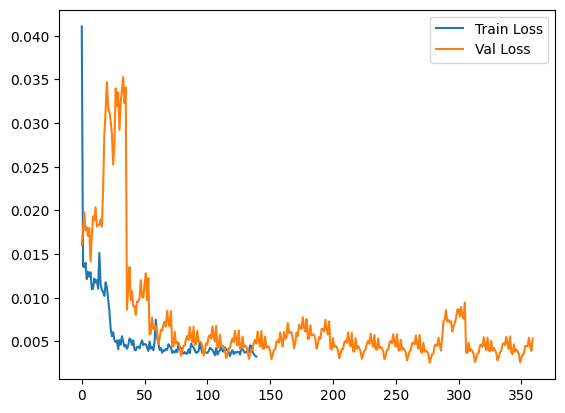

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.show()

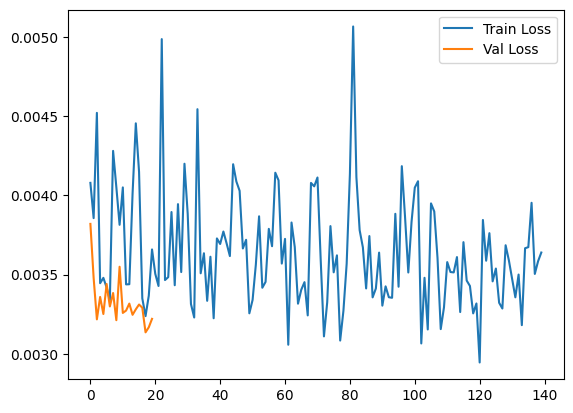

In [ ]:
plt.plot(train_losses1, label='Train Loss')
plt.plot(np.array(val_losses1)/10, label='Val Loss')
plt.legend()
plt.show()

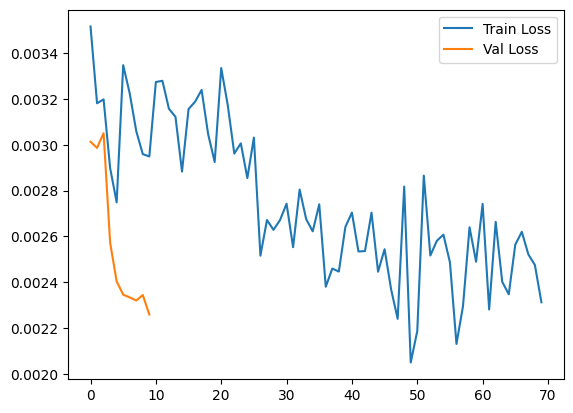

In [ ]:
plt.plot(train_losses2, label='Train Loss')
plt.plot(np.array(val_losses2)/10, label='Val Loss')
plt.legend()
plt.show()

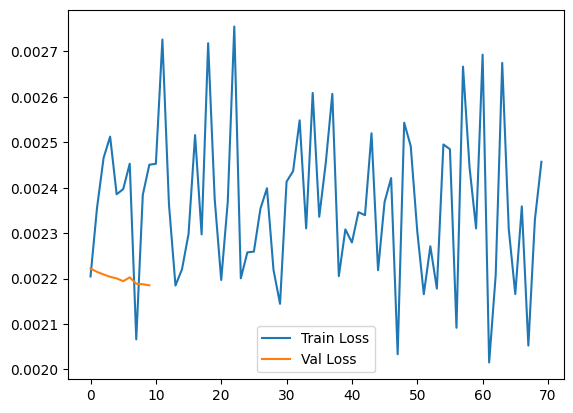

In [9]:
plt.plot(train_losses3, label='Train Loss')
plt.plot(np.array(val_losses3)/10, label='Val Loss')
plt.legend()
plt.show()

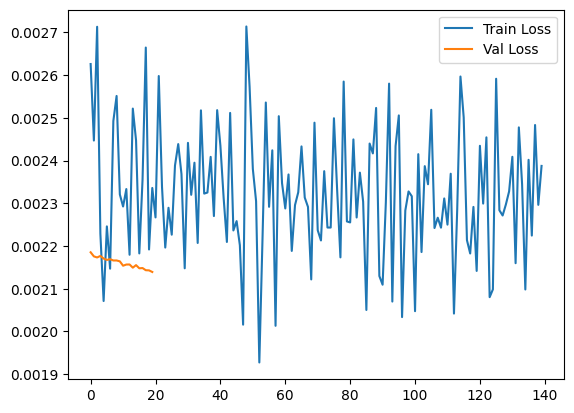

In [9]:
plt.plot(train_losses4, label='Train Loss')
plt.plot(np.array(val_losses4)/10, label='Val Loss')
plt.legend()
plt.show()

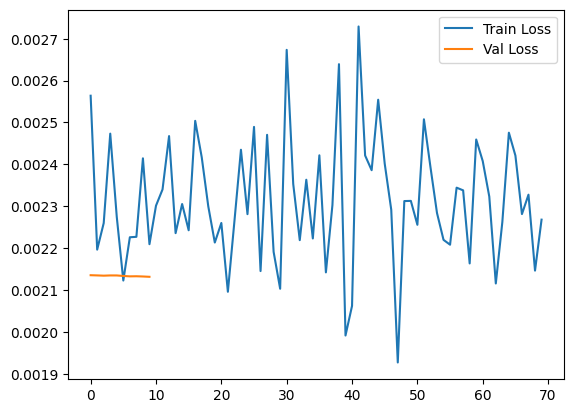

In [13]:
plt.plot(train_losses5, label='Train Loss')
plt.plot(np.array(val_losses5)/10, label='Val Loss')
plt.legend()
plt.show()

In [16]:
def show_images(model, dataloader, device):
    model.eval()
    with torch.no_grad():
        for i, (lowres, highres) in enumerate(dataloader):
            if i>=0:
                lowres = lowres.to(device)
                highres = highres.to(device)
                recon = model(lowres)

                if i >= 15:
                    break

                # plt.figure(figsize=(100, 100))
                # for j in range(lowres.shape[0]):
                #     plt.subplot(3, 10, j+1)
                #     plt.imshow(lowres[j].permute(1, 2, 0).cpu())
                #     plt.axis('off')
                #     plt.subplot(3, 10, j+11)
                #     plt.imshow(highres[j].permute(1, 2, 0).cpu())
                #     plt.axis('off')
                #     plt.subplot(3, 10, j+21)
                #     plt.imshow(recon[j].permute(1, 2, 0).cpu())
                #     plt.axis('off')
                # plt.show()

                lowres = lowres.permute(0, 2, 3, 1).cpu().numpy()[0]
                recon = recon.permute(0, 2, 3, 1).cpu().numpy()[0]
                highres = highres.permute(0, 2, 3, 1).cpu().numpy()[0]

                # Plot the images
                fig, axs = plt.subplots(3, 1, figsize=(18, 27))
                axs[0].imshow(lowres)
                axs[0].set_title("Low Resolution")
                axs[0].axis('off')
                axs[1].imshow(recon)
                axs[1].set_title("Autoencoder Output")
                axs[1].axis('off')
                axs[2].imshow(highres)
                axs[2].set_title("Ground Truth")
                axs[2].axis('off')
                plt.show()